In [42]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
from collections import defaultdict

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

import pickle
from IPython.display import clear_output 

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

In [2]:
#convert fractional betting spread strings into floats

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [3]:
start_time = datetime.now()

#import data
training_df = pd.read_csv('training_data.csv')
training_df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
print('Shape: ', training_df.shape)
training_df.columns

Shape:  (27198, 52)


Index(['Unnamed: 0', 'WL', 'MIN', 'FTM', 'PF', 'PLUS_MINUS', 'OREB', 'USG_PCT',
       'OREB_PCT', 'E_DEF_RATING', 'AST', 'FGM', 'DREB', 'DEF_RATING', 'FG3A',
       'NET_RATING', 'PTS', 'ELO', 'FG3M', 'PACE_PER40', 'FG3_PCT',
       'E_OFF_RATING', 'E_NET_RATING', 'AST_RATIO', 'TM_TOV_PCT', 'REB',
       'FT_PCT', 'FGA', 'E_TM_TOV_PCT', 'FTA', 'AST_PCT', 'POSS', 'PACE',
       'E_USG_PCT', 'AST_TOV', 'STL', 'EFG_PCT', 'TS_PCT', 'BLK', 'OFF_RATING',
       'REB_PCT', 'PIE', 'E_PACE', 'FG_PCT', 'DREB_PCT', 'TOV', 'SEASON',
       'GAME_DATE', 'GAME_ID', 'TEAM_ID_HOME', 'TEAM_CITY_HOME', 'SPREAD'],
      dtype='object')

In [4]:
#Create standardized dataset
training_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(training_df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
training_df[list(feature_cols)] = sclr.fit_transform(training_df[list(feature_cols)])
training_df.head()

,WL,MIN,FTM,PF,PLUS_MINUS,OREB,USG_PCT,OREB_PCT,E_DEF_RATING,AST,...,BLK,OFF_RATING,REB_PCT,PIE,E_PACE,FG_PCT,DREB_PCT,TOV,GAME_ID,SPREAD
0,-0.016992,-0.229406,0.404670,-1.411281,0.159391,0.311414,0.0,1.034106,-0.300081,-1.017938,...,-0.782580,-0.209162,1.202511,0.262788,-0.874297,0.049918,0.586988,0.971326,20000721,21.0
1,1.511389,0.396209,1.368804,-0.035440,1.303332,-1.674895,0.0,-1.669598,-1.617526,0.102711,...,-2.371226,0.339585,-0.612068,1.769843,-0.721879,-0.425554,1.049826,-1.327725,20000711,2.0
2,0.206409,0.244144,-0.455594,-0.669129,0.208704,1.227092,0.0,1.082764,-0.223413,0.117051,...,0.201017,0.134603,1.646374,0.454775,0.749860,0.523098,1.186924,1.109593,20000726,19.0
3,0.366996,-0.482191,-0.150914,-1.422719,0.079000,0.754982,0.0,0.875168,0.714151,0.262682,...,0.154537,0.896134,0.847898,0.264774,-0.075834,1.300811,-0.638708,0.217327,20000734,-20.0
4,-0.415606,-0.385156,0.017536,0.014806,-0.358371,2.374091,0.0,1.935370,1.752350,1.832468,...,1.458831,1.081602,1.289748,-0.530627,1.104483,0.444233,0.376923,-0.447850,20000729,-7.0


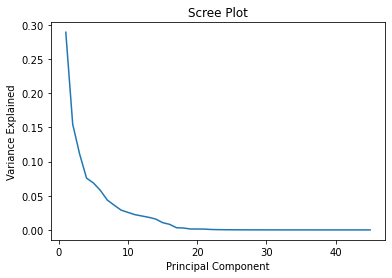

In [5]:
#PCA to minimize multicollinearity
pca = PCA().fit(training_df[list(feature_cols)])
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [6]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = training_df[list(non_feature_cols)].copy()

df_pca = pd.DataFrame(pca.fit_transform(training_df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,0.921976,-2.146900,-2.460733,1.120665,-1.761254,-0.452624,1.119262,-0.663066,-0.410643,-1.105213,...,-0.282082,-1.544775,-0.900550,0.137079,0.038758,-0.196785,0.242208,-0.069132,20000721,21.0
1,-4.190672,-2.600735,1.861792,0.697790,-0.520923,-1.884194,-3.035097,1.143921,-2.594843,0.469098,...,-2.275690,-1.072344,-0.883910,-0.214702,-0.158418,-0.180932,-0.086796,0.311843,20000711,2.0
2,-1.168993,1.448401,-3.122693,-0.743124,0.874135,-0.310195,2.661085,0.336003,0.575958,-0.661302,...,-1.838836,-0.376442,-0.861972,0.046072,-0.580808,-0.009028,0.015247,-0.062907,20000726,19.0
3,-1.631536,0.282883,-0.707663,-0.566931,-0.781657,1.701270,2.293772,0.540647,1.165011,-0.954931,...,-0.136680,-0.571499,-1.019391,-0.833450,0.253202,0.360490,-0.041421,-0.187040,20000734,-20.0
4,-1.349064,3.822397,-0.246166,-3.133159,1.910998,3.858545,1.902862,0.038047,-0.641724,-0.226469,...,0.596319,1.002352,-0.473085,1.073567,-0.026999,0.171547,-0.086132,-0.142364,20000729,-7.0


In [7]:
#split data into X_train and y_train
y_train = df_pca['SPREAD'].copy()
X_train = df_pca.drop(columns=['SPREAD', 'GAME_ID'])
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.921976,-2.146900,-2.460733,1.120665,-1.761254,-0.452624,1.119262,-0.663066,-0.410643,-1.105213,0.252116,-0.817244,-0.282082,-1.544775,-0.900550,0.137079,0.038758,-0.196785,0.242208,-0.069132
1,-4.190672,-2.600735,1.861792,0.697790,-0.520923,-1.884194,-3.035097,1.143921,-2.594843,0.469098,-2.133990,-0.300726,-2.275690,-1.072344,-0.883910,-0.214702,-0.158418,-0.180932,-0.086796,0.311843
2,-1.168993,1.448401,-3.122693,-0.743124,0.874135,-0.310195,2.661085,0.336003,0.575958,-0.661302,0.389069,-0.276915,-1.838836,-0.376442,-0.861972,0.046072,-0.580808,-0.009028,0.015247,-0.062907
3,-1.631536,0.282883,-0.707663,-0.566931,-0.781657,1.701270,2.293772,0.540647,1.165011,-0.954931,1.116336,0.283811,-0.136680,-0.571499,-1.019391,-0.833450,0.253202,0.360490,-0.041421,-0.187040
4,-1.349064,3.822397,-0.246166,-3.133159,1.910998,3.858545,1.902862,0.038047,-0.641724,-0.226469,1.267327,0.598742,0.596319,1.002352,-0.473085,1.073567,-0.026999,0.171547,-0.086132,-0.142364


In [8]:
#XGBoost implementation
xgb = pickle.load(open('model_latest.pkl', 'rb'))
xgb.fit(X_train, y_train)

#pickle updated model
pickle.dump(xgb, open('model.pkl', 'wb'))

In [9]:
#load data for evaluation
eval_df = pd.read_csv('eval_data.csv')
eval_df.drop(columns=['Unnamed: 0',
                 'GAME_DATE',
                 'SEASON',
                 'HOME_TEAM_ID',
                 'HOME_TEAM_CITY'], inplace=True)
eval_df.head()

,WL,MIN,FTM,PF,PLUS_MINUS,OREB,USG_PCT,OREB_PCT,E_DEF_RATING,AST,...,BLK,OFF_RATING,REB_PCT,PIE,E_PACE,FG_PCT,DREB_PCT,TOV,GAME_ID,SPREAD
0,-0.337946,0.571988,0.992582,-0.924691,-7.374078,-0.460093,0.0,-0.012904,4.345179,3.304436,...,1.286965,-3.428647,-0.002641,-0.012569,2.785737,0.006042,0.010007,0.461064,NaN,NaN
1,-0.346603,-0.867840,-0.472507,0.121539,-11.583978,-4.680069,0.0,-0.083183,1.665538,2.185704,...,-0.552913,-9.995969,-0.022719,-0.030014,3.731440,-0.018866,0.022861,2.105635,NaN,NaN
2,0.449002,-0.666639,0.443008,-1.864839,17.596592,-1.581533,0.0,-0.046567,-15.658195,-0.445942,...,0.799965,3.846670,0.004654,0.109098,-2.475966,0.014684,0.016496,-1.296305,NaN,NaN
3,-0.113161,-0.660396,-1.164254,2.821211,-1.303049,0.101116,0.0,0.016458,0.156865,0.041121,...,0.426050,-0.434618,-0.005979,-0.014156,1.190999,-0.003096,-0.036203,2.011866,NaN,NaN
4,0.241682,-1.032523,2.926102,-0.720527,7.093560,0.895801,0.0,0.013332,-0.506864,-0.166527,...,-1.675951,6.213128,0.039488,0.027397,3.553438,0.019627,0.059176,0.477239,NaN,NaN


In [10]:
#standardize features for eval data
eval_df[list(feature_cols)] = sclr.transform(eval_df[list(feature_cols)])

#pca on eval data
eval_df = pd.DataFrame(pca.transform(eval_df[list(feature_cols)]))

eval_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.523868,2.838480,0.730311,0.471793,2.184919,1.816028,-0.595462,2.434894,0.066188,-0.310763,0.965328,0.116698,-1.847131,-0.450896,-0.004108,1.366478,0.011362,-0.574170,0.198054,0.085000
1,3.771220,1.932957,1.480034,3.613804,2.670993,-2.686297,0.497903,3.473516,-1.422820,-0.104733,0.193052,0.990395,0.231277,0.112203,0.483556,0.043811,0.269460,-0.257773,0.487435,0.625442
2,-6.755964,-4.397669,-1.851504,0.455849,0.814690,-2.751055,-1.259076,0.213376,0.788780,0.295776,-0.585948,0.954490,1.193287,-0.140382,0.105591,-0.918644,0.624341,-0.720399,-0.705057,-0.213050
3,0.968692,1.143675,-0.563477,2.009077,-0.794104,-0.428560,0.737578,-2.221908,-0.218192,0.223632,0.721627,0.098045,0.157051,0.887158,0.175516,-0.512613,0.391374,-0.288863,0.335109,0.056949
4,-4.085437,1.909594,-2.880867,-1.275575,-1.048250,-1.047746,1.384767,0.796081,-1.239702,-1.571726,-1.293445,-1.300488,0.656835,-0.356719,0.186406,0.547294,-0.062257,0.084723,-0.160780,0.090809


In [11]:
#generate spread predictions
y_pred = xgb.predict(eval_df)
y_pred

array([-2.260802  , -6.986599  , 12.983214  , -0.05824432,  9.400148  ,
        0.48778352,  1.2411057 ,  9.788942  ,  2.658452  , -3.6977818 ],
      dtype=float32)

In [12]:
#import betting data
spreads_df = pd.read_csv('daily_spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)
spreads_df.head()

,GM_DATE,AWAY_TEAM,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2022-04-01,Dallas,Washington,-7½,-110,-7½,-110,NaN,-,-7½,-118,+7½,-110,+7½,-110,NaN,-,+7½,-118
1,2022-04-01,Toronto,Orlando,-11½,-110,-11½,-107,NaN,-,-10½,-125,+11½,-110,+11½,-114,NaN,-,+11½,-111
2,2022-04-01,Indiana,Boston,+15,-110,+15½,-109,NaN,-,+14½,100,-15,-110,-15½,-112,NaN,-,-15½,-118
3,2022-04-01,Sacramento,Houston,-3,-110,-3½,-110,NaN,-,-3½,-111,+3,-110,+3½,-110,NaN,-,+3½,-125
4,2022-04-01,L.A. Clippers,Milwaukee,+3½,-105,+3½,-109,NaN,-,+3½,-118,-3½,-115,-3½,-112,NaN,-,-3½,-118


In [13]:
print(len(y_pred))
print(len(spreads_df))

10
10


In [14]:
#compare predicted spreads against betting spreads

def eval_spreads(spreads, preds):
    
    output = spreads[['GM_DATE', 'HOME_TEAM', 'AWAY_TEAM']].copy()
    book_spread = np.empty(len(output))
    book_num = np.empty(len(output))
    
    for i, row in spreads.iterrows():
        
        away_spreads = np.empty(4)
        
        away_spreads[0] = convert_to_float(row['SPREAD_1_AWAY'])
        away_spreads[1] = convert_to_float(row['SPREAD_2_AWAY'])
        away_spreads[2] = convert_to_float(row['SPREAD_3_AWAY'])
        away_spreads[3] = convert_to_float(row['SPREAD_4_AWAY'])
      
        pred = preds[i]
        
        spread_diffs = np.empty(4)
        
        for j, spread in enumerate(away_spreads):
            spread_diffs[j] = abs(pred - spread)
        
        book_w_max_diff = np.nanargmax(spread_diffs)
        book_num[i] = book_w_max_diff
        book_spread[i] = away_spreads[book_w_max_diff]
        
    output['BOOK_NUM'] = book_num
    output['BOOK_SPREAD'] = book_spread
    output['PRED_SPREAD'] = preds
    output['SPREAD_DIFF'] = abs(output['PRED_SPREAD'] - output['BOOK_SPREAD'])
    
    return output
        

In [87]:
bets = eval_spreads(spreads_df, y_pred)

In [88]:
bets

,GM_DATE,HOME_TEAM,AWAY_TEAM,BOOK_NUM,BOOK_SPREAD,PRED_SPREAD,SPREAD_DIFF
0,2022-04-01,Washington,Dallas,0.0,-7.5,-2.260802,5.239198
1,2022-04-01,Orlando,Toronto,0.0,-11.5,-6.986599,4.513401
2,2022-04-01,Boston,Indiana,1.0,15.5,12.983214,2.516786
3,2022-04-01,Houston,Sacramento,1.0,-3.5,-0.058244,3.441756
4,2022-04-01,Milwaukee,L.A. Clippers,0.0,3.5,9.400148,5.900148
5,2022-04-01,Oklahoma City,Detroit,1.0,-5.0,0.487784,5.487784
6,2022-04-01,Memphis,Phoenix,0.0,-8.0,1.241106,9.241106
7,2022-04-01,San Antonio,Portland,0.0,13.5,9.788942,3.711058
8,2022-04-01,Denver,Minnesota,0.0,3.0,2.658452,0.341548
9,2022-04-01,L.A. Lakers,New Orleans,0.0,2.0,-3.697782,5.697782


In [89]:
book_dict = {0:'bet365', 1:'888sport', 2:'unibet', 3:'betway'}

In [90]:
#function to send email notifications
def send_notification(bets_df, recipients, confidence_thresh=20):

    #filter df for only bets that meet confidence threshold criteria
    ##########UNCOMMENT LINE BELOW BEFORE USE#########
    #bets_df = bets_df[bets_df['SPREAD_DIFF'] >= confidence_thresh]
    
    
    #replace book numbers with book names
    bets_df['BOOK_NUM'].replace(to_replace=book_dict, inplace=True)
    bets_df.rename(columns={'BOOK_NUM':'BOOK_NAME'}, inplace=True)
    
    if len(bets_df)==0:
        print('No recommended bets available')
        return
    
    recommended_bet_on = []
    
    for i, row in bets_df.iterrows():
        home_team = row['HOME_TEAM']
        away_team = row['AWAY_TEAM']
        
        if row['PRED_SPREAD'] >= row['BOOK_SPREAD']:
            recommended_bet_on.append(home_team)
        else:
            recommended_bet_on.append(away_team)
    
    bets_df['RECOMMENDED_BET_ON'] = recommended_bet_on
    
    #create email notification
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = 'Bet Recommendations for {}'.format(date.today())
    msg['From'] = 'jnshzk@gmail.com'
    
    part1 = 'Hello,\n There are recommended bets available today ({}).  Please see details below:'.format(date.today())
    msg.attach(MIMEText(part1))
    
    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(bets_df.to_html())
    
    part2 = MIMEText(html, 'html')
    msg.attach(part2)
    
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login('jnshzk@gmail.com', 'password')
    server.sendmail(msg['From'], emaillist, msg.as_string())
    server.quit()
    #return bets_df

In [91]:
send_notification(bets, ['jnshzk@gmail.com'])

SMTPAuthenticationError: (535, b'5.7.8 Username and Password not accepted. Learn more at\n5.7.8  https://support.google.com/mail/?p=BadCredentials s6-20020a05620a0bc600b006b5f68bc106sm9076253qki.110 - gsmtp')

In [19]:
print('Runtime: ', datetime.now() - start_time)

Runtime:  0:00:06.833573
